# Introduction and purpose of this file

The point of this is to remodify lookat_layers_270 with the new ASTE run sent from An:
- forward run: run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro
- year 2007 with the layers diagnostics: run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro

We will try to compare them here and see if we get the same thing

# Import the files and functions for run 1

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [33]:
forward_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
imgpath = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/BarentsS_paper/figs/"
dirdiags = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS_Cwet/"
dirrun = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
dirState = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/STATE/"

In [199]:
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0

# define the years of this that we want to read from
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
# times["2007"] = np.arange(1,13,1)
# times["2008"] = np.array([1])
# times["2007"] = np.arange(11,13,1)
times["2008"] = np.arange(1,3,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

tsteps = len(datetimes)-1
tsteps

1

In [200]:
names[-1]

'0000315504'

In [201]:
tsstr

array(['0000315504', '0000319968'], dtype='<U32')

In [202]:
# set up the mask - we can try and use the Barents Sea mask here but not sure
data = np.load('masks_BS.npz')

# Access the saved masks
mask_south = data['mask_south']  # mask for heating and freshening (southern region)
mask_north = data['mask_north']  # mask for heating and salting (northern region)
mask_north_subsect = data['mask_north_subsect']  # mask for maximum location of change for heating and salting
mask_BS = data['mask_BS']

mask_south[mask_south == 0] = np.nan
mask_north[mask_north == 0] = np.nan
mask_north_subsect[mask_north_subsect == 0] = np.nan
mask_BS[mask_BS == 0] = np.nan

# set mymsk for the run below
mymsk = mask_BS
iB = 6
titlestr = "BarentsS"

### Do the budgeting and get the J terms

In [203]:
# we will use the bins from the An run so that we have the same thing in both sections
# Paths for the bins in this run
copypath = "/scratch/mmurakami/ASTE_270/LAYERS_copies/"
filename = "layers2TH"
boundsT = rdmds(copypath + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1
# boundsT

filename = "layers1SLT"
boundsS = rdmds(copypath + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1
# boundsS

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

In [204]:
# set a larger array for one year of the terms
nS,nT = 112,112
vol_mesh_all = np.zeros((tsteps,nS,nT))
JtermsT_all = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all = np.zeros((tsteps,5,nS,nT))

In [205]:
# reset the mean volume based on the terms
JtermsT = np.nanmean(JtermsT_all,axis=0)
JtermsS = np.nanmean(JtermsS_all,axis=0)
vol_mesh = np.nanmean(vol_mesh_all,axis=0)
JtermsS_nn = np.nanmean(JtermsS_nn_all,axis=0)
JtermsT_nn = np.nanmean(JtermsT_nn_all,axis=0)

In [206]:
for i in range(len(datetimes)-1):
    print(datetimes[i])
    tsstrhere = tsstr[i:i+2]
    datetimeshere = datetimes[i:i+2]
    dt = datetimes[i+1]-datetimes[i]
    dt = dt.total_seconds()
    t2 = int(tsstr[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,iB,RAC,RAC3,myparms)

    vol_mesh_all[i] = vol_mesh
    JtermsT_all[i] = JtermsT
    JtermsS_all[i] = JtermsS
    JtermsT_nn_all[i] = JtermsT_nn
    JtermsS_nn_all[i] = JtermsS_nn

2008-01-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -1.679657497380022e-11 Sv/PSU
doing JtermsS
total residual -0.0381585122285505 Sv/degC
doing not normalized J terms
total residual -1.679657497380022e-11 Sv
total residual -0.0381585122285505 Sv


In [207]:
tsstrhere

array(['0000315504', '0000319968'], dtype='<U32')

In [208]:
# do the time-averaging -- setting this from January onward because this is what we have listed
# JtermsT = np.nanmean(JtermsT_all[1:],axis=0)
# JtermsS = np.nanmean(JtermsS_all[1:],axis=0)
# vol_mesh = np.nanmean(vol_mesh_all[1:],axis=0)

# JtermsS_nn = np.nanmean(JtermsS_nn_all[1:],axis=0)
# JtermsT_nn = np.nanmean(JtermsT_nn_all[1:],axis=0)

JtermsT = np.nanmean(JtermsT_all,axis=0)
JtermsS = np.nanmean(JtermsS_all,axis=0)
vol_mesh = np.nanmean(vol_mesh_all,axis=0)

JtermsS_nn = np.nanmean(JtermsS_nn_all,axis=0)
JtermsT_nn = np.nanmean(JtermsT_nn_all,axis=0)

### Create the T-S mesh for this (I think we should be able to use the same one in the layers)

In [209]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [210]:

# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


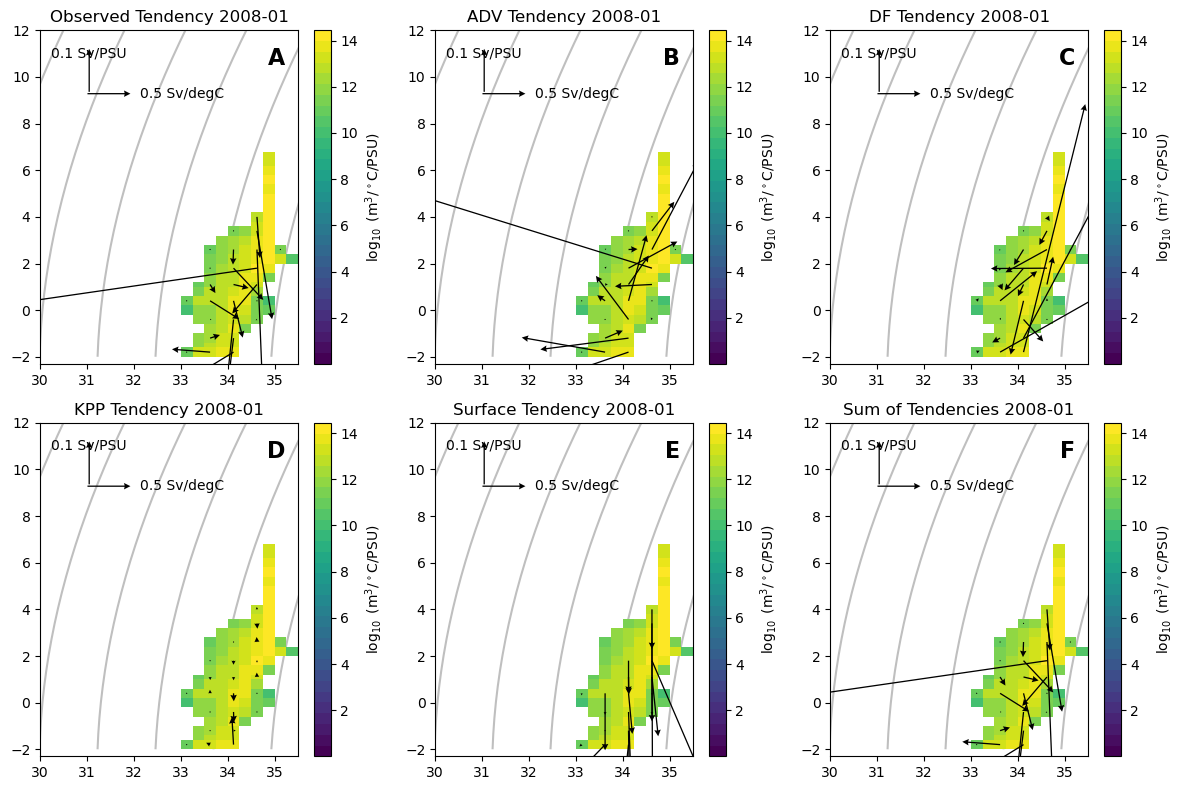

In [211]:
# do a sample plot of the tendency terms here
alpha, beta = 1, 0.2
arrow_length, step, t, U, scale = 0.25, 2, 0, 0.5, 3e0
ypos1, ypos2, xpos1, xpos2 = 0.81, 0.88, 0.35, 0.19

# Time string for labeling
timestr = datetimes[0].strftime("%Y-%m")
# timestr = datetimes[0].strftime("%Y")

# Plot limits
xlims, ylims = np.array([30, 35.5]), np.array([-2.3, 12])

# Titles for each subplot
titles = [
    "Observed Tendency", "ADV Tendency", "DF Tendency",
    "KPP Tendency", "Surface Tendency", "Sum of Tendencies"
]

# Figure setup
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 subplot layout
axes = axes.flatten()  # Flatten to iterate easily

for i, ax in enumerate(axes):
    if i < 5:
        U1, V1 = JtermsS[i], JtermsT[i]  # Select tendency terms
    else:
        # Sum up all terms for the last plot
        U1, V1 = sum(JtermsS[1:5]), sum(JtermsT[1:5])

    # Apply scaling and set zero values to NaN
    U1, V1 = U1 * alpha, V1 * beta
    U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan

    # Background colormap
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01, zorder=2)

    # Quiver plot
    q = ax.quiver(Sbincent[::step, ::step], Tbincent[::step, ::step], 
                  U1[::step, ::step], V1[::step, ::step], 
                  width=0.005, scale=scale, zorder=3, headwidth=5)

    # Colorbar
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')

    # Titles, limits, and labels
    ax.set_title(f"{titles[i]} {timestr}")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Quiver key (for scale reference)
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta} Sv/PSU", angle=90, labelpos='N', coordinates='axes')

    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# Save figure
plt.tight_layout()
# plt.savefig(imgpath + titlestr + "BarentsS" + timestr + ".png", dpi=300)
plt.show()

# Import the files for run 2, the one with layers

In [212]:
ts2dte(int(names[0]))

datetime.datetime(2002, 3, 3, 0, 0)

In [213]:
# check that we are reading the same timesteps

In [214]:
# we will be using the same tsstr values, check these are the ones listed
tsstr

array(['0000315504', '0000319968'], dtype='<U32')

In [215]:
names = np.array(['0000267408','0000280224','0000293472','0000306720','0000271440','0000284688',  '0000297936',  '0000311040','0000275904',  '0000289008',  '0000302256',  '0000315504'])

In [216]:
tsstr = np.sort(tsstr)
names = np.sort(names)

In [217]:
for i,j in zip(tsstr,names):
    print(i,j)

0000315504 0000267408
0000319968 0000271440


In [218]:
for fname in names:
    print(ts2dte(int(fname)))

2002-03-03 00:00:00
2002-04-28 00:00:00
2002-06-29 00:00:00
2002-08-28 00:00:00
2002-10-29 00:00:00
2002-12-28 00:00:00
2003-02-28 00:00:00
2003-05-01 00:00:00
2003-06-30 00:00:00
2003-08-31 00:00:00
2003-10-30 00:00:00
2003-12-31 00:00:00


In [219]:
for fname in tsstr:
    print(ts2dte(int(fname)))

2003-12-31 00:00:00
2004-03-02 00:00:00


In [220]:
# we need to drop the first month of this from the previous calculation

### see if we can load for one month from the layers

Key from available_diagnostics.log for Ttend:

- LaTs2TH (m/s): Layer thickness tendency due to THETA surf. forc.
- LaTh2TH (m/s): Layer thickness tendency due to THETA horiz. diff.
- LaTz2TH (m/s): Layer thickness tendency due to THETA vert. diff.
- TzKp2TH (m/s): Layer thickness tendency due to THETA vert. diff. (KPP part)
- TzRe2TH (m/s): Layer thickness tendency due to THETA vert. diff. (Redi part)
- TzBg2TH (m/s): Layer thickness tendency due to THETA vert. diff. (Bolus part)?
- TKpg2TH: ?
- LTha2TH (m/s): Layer thickness tendency due to THETA horiz. adv.
- LTza2TH (m/s): Layer thickness tendency due to THETA vert. adv.
- LTBh2TH (m/s): Layer thickness tendency due    to THETA horiz. adv. (bolus part)
- LTBz2TH (m/s): Layer thickness tendency due to THETA vert. adv. (bolus)?
- LTto2TH (m/day): Layer thickness tendency due to all THETA terms.
- LaTs1SLT (m/s): Layer thickness tendency due to THETA surf. forc.
- LaTh1SLT (m/s): Layer thickness tendency due to THETA horiz. diff.
- LaTz1SLT (m/s): Layer thickness tendency due to THETA vert. diff.
- TzKp1SLT (m/s): Layer thickness tendency due to THETA vert. diff. (KPP part)
- TzRe1SLT (m/s): Layer thickness tendency due to THETA vert. diff. (Redi part)
- TzBg1SLT (m/s): bolus?
- TKpg1SLT: ?
- LTha1SLT (m/s): Layer thickness tendency due to THETA horiz. adv.
- LTza1SLT (m/s): Layer thickness tendency due to THETA vert. adv.
- LTBh1SLT (m/s): Layer thickness tendency due    to THETA horiz. adv. (bolus part)
- LTBz1SLT (m/s): Layer thickness tendency due to THETA vert. adv. (bolus)
- LTto1SLT (m/day): Layer thickness tendency due to all THETA terms.


Key from available_diagnostics.log for Stend:

- LaSs2TH (m/s): Layer thickness tendency due to SALT surf. forc.
- LaSh2TH (m/s): Layer thickness tendency due to SALT horiz. diff.
- LaSz2TH (m/s): Layer thickness tendency due to SALT vert. diff.
- SzKp2TH (m/s): Layer thickness tendency due to SALT vert. diff. (KPP part)
- SzRe2TH (m/s): Layer thickness tendency due to SALT vert. diff. (Redi part)
- SzBg2TH (m/s): Layer thickness tendency due to SALT vert. diff. (Bolus part)?
- SKpg2TH: ?
- LSha2TH (m/s): Layer thickness tendency due to SALT horiz. adv.
- LSza2TH (m/s): Layer thickness tendency due to SALT vert. adv.
- LSBh2TH (m/s): Layer thickness tendency due to SALT horiz. adv. (bolus part)
- LSBz2TH (m/s): Layer thickness tendency due to SALT vert. adv. (bolus part)
- LSto2TH (m/day): Layer thickness tendency due to all SALT terms.
- LaSs1SLT (m/s): Layer thickness tendency due to SALT surf. forc.
- LaSh1SLT (m/s): Layer thickness tendency due to SALT horiz. diff.
- LaSz1SLT (m/s): Layer thickness tendency due to SALT vert. diff.
- SzKp1SLT (m/s): Layer thickness tendency due to SALT vert. diff. (KPP part)
- SzRe1SLT (m/s): Layer thickness tendency due to SALT vert. diff. (Redi part)
- SzBg1SLT (m/s): Layer thickness tendency due to SALT vert. diff. (Bolus part)?
- SKpg1SLT: ?
- LSha1SLT (m/s): Layer thickness tendency due to SALT horiz. adv.
- LSza1SLT (m/s): Layer thickness tendency due to SALT vert. adv.
- LSBh1SLT (m/s): Layer thickness tendency due to SALT horiz. adv. (bolus part)
- LSBz1SLT (m/s): Layer thickness tendency due to SALT vert. adv. (bolus part)
- LSto1SLT (m/day): Layer thickness tendency due to all SALT terms.

In [221]:
dirdiags = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS/"

In [222]:
# ffac=1e-6
# G_T=np.array([])
# metaT=parsemeta(dirdiags + "LAYERS/layers_3d_Ttend" 0000723024.meta")
# metaS=parsemeta(dirdiags + "LAYERS/layers_3d_Stend" 0000723024.meta")
# nFldsS = metaS["fldList"]
# nFldsT = metaT["fldList"]

In [223]:
# try to just plot the total tendency from the Ttend files
ffac = 1e-6
dirInLayers = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS/"
dirInBudg = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/BUDG/"

file_name = "layers_3d_Ttend"

meta_layers_3d_Ttend = parsemeta(dirInLayers + file_name + "." + names[0] + ".meta")
fldlist = np.array(meta_layers_3d_Ttend["fldList"])
print(fldlist)
varnames = np.array(["LTto2TH","LTto1SLT"])
# recs = np.array([])
# for var in varnames:
#     irec = np.where(fldlist == var)
#     recs = np.append(recs, irec[0][0])
# ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
# ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
# DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
# DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'TzKp2TH' 'TzRe2TH' 'TzBg2TH' 'TKpg2TH'
 'LTha2TH' 'LTza2TH' 'LTBh2TH' 'LTBz2TH' 'LTto2TH' 'LaTs1SLT' 'LaTh1SLT'
 'LaTz1SLT' 'TzKp1SLT' 'TzRe1SLT' 'TzBg1SLT' 'TKpg1SLT' 'LTha1SLT'
 'LTza1SLT' 'LTBh1SLT' 'LTBz1SLT' 'LTto1SLT']


In [224]:
# try to do a plot of the total tendency from the Stend files
# try to just plot the total tendency
ffac = 1e-6
dirInLayers = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS/"
file_name = "layers_3d_Stend"

meta_layers_3d_Ttend = parsemeta(dirInLayers + file_name + "." + names[0] + ".meta")
fldlist = np.array(meta_layers_3d_Ttend["fldList"])
print(fldlist)
varnames = np.array(["LTto2TH","LTto1SLT"])
# recs = np.array([])
# for var in varnames:
#     irec = np.where(fldlist == var)
#     recs = np.append(recs, irec[0][0])
# ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
# ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
# DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
# DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

['LaSs2TH' 'LaSh2TH' 'LaSz2TH' 'SzKp2TH' 'SzRe2TH' 'SzBg2TH' 'SKpg2TH'
 'LSha2TH' 'LSza2TH' 'LSBh2TH' 'LSBz2TH' 'LSto2TH' 'LaSs1SLT' 'LaSh1SLT'
 'LaSz1SLT' 'SzKp1SLT' 'SzRe1SLT' 'SzBg1SLT' 'SKpg1SLT' 'LSha1SLT'
 'LSza1SLT' 'LSBh1SLT' 'LSBz1SLT' 'LSto1SLT']


## create the volume distribution for one month

In [225]:
names

array(['0000267408', '0000271440', '0000275904', '0000280224',
       '0000284688', '0000289008', '0000293472', '0000297936',
       '0000302256', '0000306720', '0000311040', '0000315504'],
      dtype='<U10')

In [226]:
# assuming all files are structured the same

file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirInBudg + file_name + "." + names[-1]+ ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))

# read the first timestep as an example
t1 = names[0]
read = [int(t1)]

# make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
ETAN,its,meta = rdmds(os.path.join(dirInBudg, file_name),read,returnmeta=True,rec=recs[0])

# choose by basin
ETAN = np.reshape(ETAN,(ny,nx))

# 3D, with rStar:
tmpvol = np.zeros((nz, ny, nx))
if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
    tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
    if myparms['useRFWF'] == 0:
        tmpvol[0, :, :] = np.zeros((ny, nx))
else:    # 4/22 look at this one
    if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
        tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
        tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
    else:
        tmp2 = drf3d / mk3D_mod(DD, tmp1)

    # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
    tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC)     # volume, m * m^2  = m^3

tmpvol = tmpvol * np.tile(mymsk, (nz, 1, 1))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/BUDG/budg2d_snap_set1.0000315504.meta'

In [ ]:
print(names[-1],tsstrhere)

In [110]:
# load the THETA to do the binning
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + names[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
SALT = SALT.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

In [111]:
# bin the volume we masked
binned_theta = bin_array(THETA,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(SALT,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [112]:
# create the volume mesh
maskArc = mskBasin * mymsk   # this is somewhat redundant and we are not actually using iB below

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
mesh = create_TS_mesh(np.array(names[0]).reshape(1),nS,nT,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),tmpvol.reshape(1,nz,ny,nx),idxs,dT,dS)

# sum the volume from the points in dimension 2
vol_mesh = np.nansum(mesh[0],axis=2)

<a list of 15 text.Text objects>

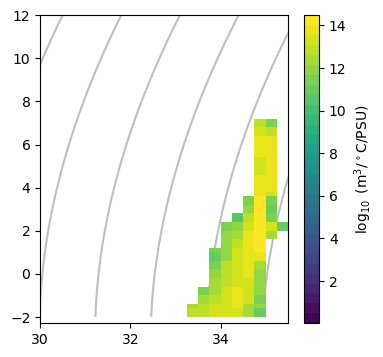

In [114]:
# now plot a sample TS diagram of this without the tendency terms
xlims, ylims = np.array([30, 35.5]), np.array([-2.3, 12])

fig = plt.figure(figsize = (4,4))

ax = plt.subplot(111)
cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, zorder=2,vmin=0.01)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# Now we can try to plot the above with some quivers, but this already looks different

In [115]:
# tsstr = '0000723024'
names[0]

'0000267408'

In [132]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(dirdiags + "layers_3d_Ttend.0000267408.meta")
metaS=parsemeta(dirdiags + "layers_3d_Stend.0000267408.meta")
nFldsS = metaS["fldList"]
nFldsT = metaT["fldList"]

In [139]:
# metaT['fldList']  # 0, 1, 2, 7, 
metaS['fldList']   # 13, 14, 15, 16, 19, 22
a = metaS['fldList']
print(a[11],a[12],a[13],a[16],a[19],a[22])  # these are the ifldS values
# these are the total tend due to salt terms, tend due to salt surf forcing, tend due to salt horizontal diff, tend due to salt vertical diff
# ... tend due to salt horiz adv, tend due to salt vertical adv
ifldS = np.array([11,12,13,16,19,22])  # total tend, surf, hDiff, vDiff, hADV, vADV

LSto2TH LaSs1SLT LaSh1SLT SzRe1SLT LSha1SLT LSBz1SLT


In [140]:
# from before ([0,1,2,3,4,7])

In [141]:
metaT['fldList']   # 13, 14, 15, 16, 19, 22
a = metaT['fldList']
print(a[0],a[1],a[2],a[7],a[8],a[11])
ifldT = np.array([0,1,2,7,8,11])    # surf, hDiff, vDiff, hADV, vADV, total tend

LaTs2TH LaTh2TH LaTz2TH LTha2TH LTza2TH LTto2TH


In [142]:
dirdiags

'/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS/'

In [147]:
tsstr

array(['0000267408', '0000271440'], dtype='<U32')

In [148]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/GRID_wet/"

In [150]:
# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
# TEST, ask An
# rac2d = rac2d.reshape((LwetC2d,2))
# rac2d = rac2d[:,0]
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape
hf2dtile = np.tile(hf2d,(nT-1,1))

RAC2d (146614,)
(4833023,)


In [153]:
setTtend=nFldsT.copy()
setStend=nFldsS.copy()

# define the G_T and G_S terms

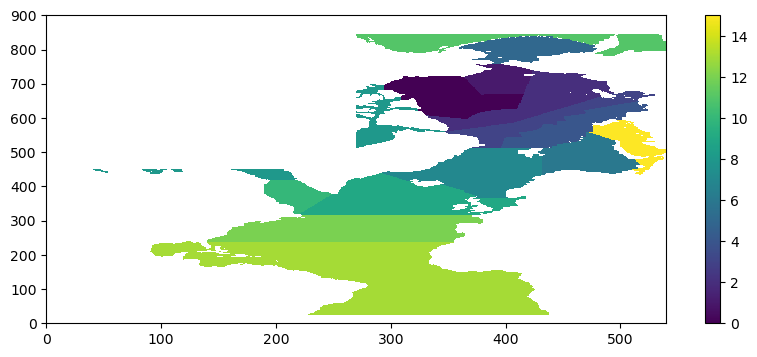

In [176]:
ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()
ind2d = mskBasin.reshape(364500)
ind2d.shape
iBarentsS2D = np.where(ind2d == 7)[0]

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 7)[0]

In [180]:
# make the G_T term
G_T = {}
    
# now loop through
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float32_skip(dirdiags + "layers_3d_Ttend." + tsstr[0] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldT.shape[0]-1:
        residT = tmp
    else:
        residT = residT-tmp

    # just do the Barents Sea for this one
    a = np.nansum(tmp[:,iwet_BarentsS2D],axis=1)
    G_T[setTtend[ifldT[i]]] = a

G_T["residT"] = np.nansum(residT[:,iwet_BarentsS2D],axis=1)

In [181]:
# create G_S for all basins (line 258)
G_S = {}
for ib in range(len(strb)):
    G_S[strb[ib]] = {}

# now loop through similar to ifldS
for i in range(len(ifldS)-1, -1, -1):
    tmp = read_float32_skip(dirdiags + "layers_3d_Stend." + tsstr[0] + ".data", nx*ny*(nT-1),ifldS[i])
    tmp = np.reshape(tmp,(nS-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldS.shape[0]-1:
        residS = tmp
    else:
        residS = residS-tmp

    # just do for the Barents Sea
    a = np.nansum(tmp[:,iwet_BarentsS2D],axis=1)
    G_S[setStend[ifldS[i]]] = a

# loop through again to calculate resid
G_S["residS"] = np.nansum(residS[:,iwet_BarentsS2D],axis=1)

In [188]:
print(ts2dte(int('0000315504')))
print(ts2dte(int(tsstr[-1])))

2003-12-31 00:00:00
2002-04-28 00:00:00


## We now did G_S and G_T and these are budgeted. Can move on to calculation of J (scary)

In [ ]:
setTSp = ['LaHc_TS']

if len(nFldsT) == 18:
    setTS_Stend = ['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'SzKp_TS', 'SzRe_TS', 'LSha_TS', 'LSza_TS', 'LSBh_TS', 'LSBz_TS', 'LSto_TS']
    setTS_Ttend = ['LaTs_TS', 'LaTh_TS', 'LaTz_TS', 'TzKp_TS', 'TzRe_TS', 'LTha_TS', 'LTza_TS', 'LTBh_TS', 'LTBz_TS', 'LTto_TS']